In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
from google.colab import files
uploaded = files.upload()

data = pd.read_csv(r"dirty_cafe_sales.csv")

Saving dirty_cafe_sales.csv to dirty_cafe_sales (1).csv


In [5]:
m = data["Item"].mode()
print(m)

0    Juice
Name: Item, dtype: object


In [6]:
data.describe()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_9226047,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [8]:
#Numeric Columns: Convert Quantity, Price Per Unit, and Total Spent to numeric types:
data[['Quantity', 'Price Per Unit', 'Total Spent']] = data[['Quantity', 'Price Per Unit', 'Total Spent']].apply(pd.to_numeric, errors='coerce')

In [9]:
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce', format='%Y-%m-%d')

In [10]:
#Replace "UNKNOWN" and "ERROR" with NaN for consistency:
data.replace(['UNKNOWN', 'ERROR', 'UnKNOWN'], pd.NA, inplace=True)

In [11]:
# List of numeric columns
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent']

# Fill missing values with the median of each column
fill_dict = {col: data[col].median() for col in numeric_cols}
data.fillna(value=fill_dict, inplace=True)

In [12]:
# List of categorical columns
categorical_cols = ['Item', 'Payment Method', 'Location']

# Fill missing values with the mode (most frequent value) of each column
mode_dict = {col: data[col].mode()[0] for col in categorical_cols}
data.fillna(mode_dict, inplace=True)  # ✅ Single inplace call, no chaining

In [13]:
# Categorical Data Standardization
categorical_cols = ['Item', 'Payment Method', 'Location']

for col in categorical_cols:
    data[col] = data[col].str.upper()


In [14]:
#Check for duplicate Transaction ID:
data.drop_duplicates(subset=['Transaction ID'], inplace=True)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    10000 non-null  object        
 1   Item              10000 non-null  object        
 2   Quantity          10000 non-null  float64       
 3   Price Per Unit    10000 non-null  float64       
 4   Total Spent       10000 non-null  float64       
 5   Payment Method    10000 non-null  object        
 6   Location          10000 non-null  object        
 7   Transaction Date  9540 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 625.1+ KB


In [16]:
data.shape

(10000, 8)

In [17]:
data = data.dropna(subset=['Transaction Date'])


In [18]:
# See how many missing values exist in each column
print(data.isnull().sum())


Transaction ID      0
Item                0
Quantity            0
Price Per Unit      0
Total Spent         0
Payment Method      0
Location            0
Transaction Date    0
dtype: int64


In [19]:
print(data.dtypes)


Transaction ID              object
Item                        object
Quantity                   float64
Price Per Unit             float64
Total Spent                float64
Payment Method              object
Location                    object
Transaction Date    datetime64[ns]
dtype: object


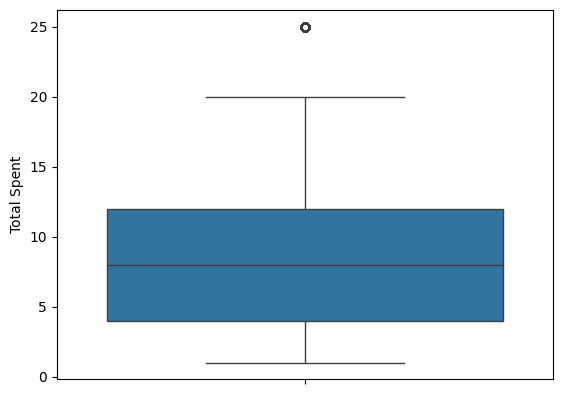

In [20]:
#detecting outlier
sns.boxplot(data['Total Spent'])
plt.show()


In [21]:
import pandas as pd

# Select only numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Loop through each numeric column and filter out outliers using IQR
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Keep only the rows where the column is within bounds
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

# Check the cleaned dataset
print("✅ Cleaned dataset shape:", data.shape)


✅ Cleaned dataset shape: (9290, 8)


In [22]:
outlier_info = {}

for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    outlier_info[col] = {
        'outlier_count': outliers.shape[0],
        'percent_of_data': 100 * outliers.shape[0] / data.shape[0]
    }

# Show summary
import pprint
pprint.pprint(outlier_info)


{'Price Per Unit': {'outlier_count': 0, 'percent_of_data': 0.0},
 'Quantity': {'outlier_count': 0, 'percent_of_data': 0.0},
 'Total Spent': {'outlier_count': 0, 'percent_of_data': 0.0}}


In [23]:
cat_cols = data.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    print(f"Value counts in '{col}':")
    print(data[col].value_counts())
    print('-' * 40)


Value counts in 'Transaction ID':
Transaction ID
TXN_6170729    1
TXN_1961373    1
TXN_4977031    1
TXN_4271903    1
TXN_7034554    1
              ..
TXN_3765707    1
TXN_2847255    1
TXN_8915701    1
TXN_9437049    1
TXN_7619095    1
Name: count, Length: 9290, dtype: int64
----------------------------------------
Value counts in 'Item':
Item
JUICE       2030
COFFEE      1123
CAKE        1082
SANDWICH    1075
SMOOTHIE    1048
COOKIE      1035
TEA         1027
SALAD        870
Name: count, dtype: int64
----------------------------------------
Value counts in 'Payment Method':
Payment Method
DIGITAL WALLET    5085
CREDIT CARD       2107
CASH              2098
Name: count, dtype: int64
----------------------------------------
Value counts in 'Location':
Location
TAKEAWAY    6498
IN-STORE    2792
Name: count, dtype: int64
----------------------------------------


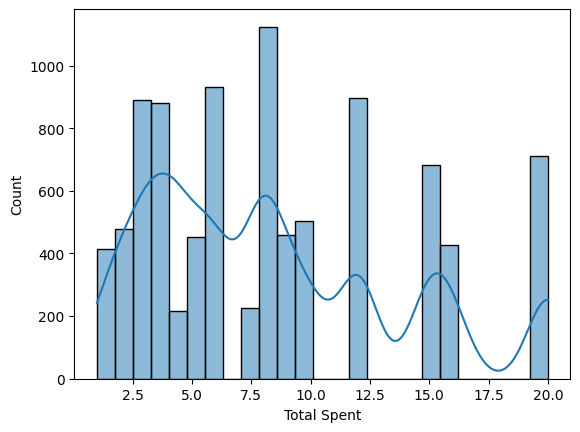

In [24]:
sns.histplot(data['Total Spent'], kde=True)
plt.show()


In [25]:
#transform the variable using log transformation
import numpy as np
data['Total Spent'] = np.log1p(data['Total Spent'])


In [26]:
print("Unique counts for categorical variables:")
print("• Item:", data['Item'].nunique())
print("• Location:", data['Location'].nunique())
print("• Payment Method:", data['Payment Method'].nunique())


Unique counts for categorical variables:
• Item: 8
• Location: 2
• Payment Method: 3


In [27]:
# Define the columns to clean
cat_cols = ['Item', 'Location', 'Payment Method']

# Replace rare categories (appearing less than 10 times) with "Other"
for col in cat_cols:
    counts = data[col].value_counts()
    rare_categories = counts[counts < 10].index
    data[col] = data[col].replace(rare_categories, 'Other')


In [28]:
print("\nUpdated counts of unique categories:")
print(data['Item'].value_counts())
print(data['Location'].value_counts())
print(data['Payment Method'].value_counts())



Updated counts of unique categories:
Item
JUICE       2030
COFFEE      1123
CAKE        1082
SANDWICH    1075
SMOOTHIE    1048
COOKIE      1035
TEA         1027
SALAD        870
Name: count, dtype: int64
Location
TAKEAWAY    6498
IN-STORE    2792
Name: count, dtype: int64
Payment Method
DIGITAL WALLET    5085
CREDIT CARD       2107
CASH              2098
Name: count, dtype: int64


In [29]:
"""Data Leakage
Why it matters: If your features include information not available at prediction time, your model will be unrealistically good and fail in production.

How to detect:

Manually inspect features. Anything from the future, or derived from the target, is leakage.

Solution:
Drop leaked columns:

# Drop the 'Revenue_after_discount' column if it's based on future data"""
if 'Revenue_after_discount' in data.columns:
    data = data.drop(columns=['Revenue_after_discount'])

In [30]:

print("Duplicate rows:", data.duplicated().sum())


Duplicate rows: 0


In [31]:
data = data.drop_duplicates()


In [32]:
data.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,COFFEE,2.0,2.0,1.609438,CREDIT CARD,TAKEAWAY,2023-09-08
1,TXN_4977031,CAKE,4.0,3.0,2.564949,CASH,IN-STORE,2023-05-16
2,TXN_4271903,COOKIE,4.0,1.0,2.197225,CREDIT CARD,IN-STORE,2023-07-19
3,TXN_7034554,SALAD,2.0,5.0,2.397895,DIGITAL WALLET,TAKEAWAY,2023-04-27
4,TXN_3160411,COFFEE,2.0,2.0,1.609438,DIGITAL WALLET,IN-STORE,2023-06-11


   Location   total_sales  total_quantity  average_spend  average_quantity  \
0  IN-STORE   5818.341421          8309.0       2.083933          2.976003   
1  TAKEAWAY  13460.129760         19317.0       2.071427          2.972761   

   average_growth  
0       -0.126086  
1        0.267046  


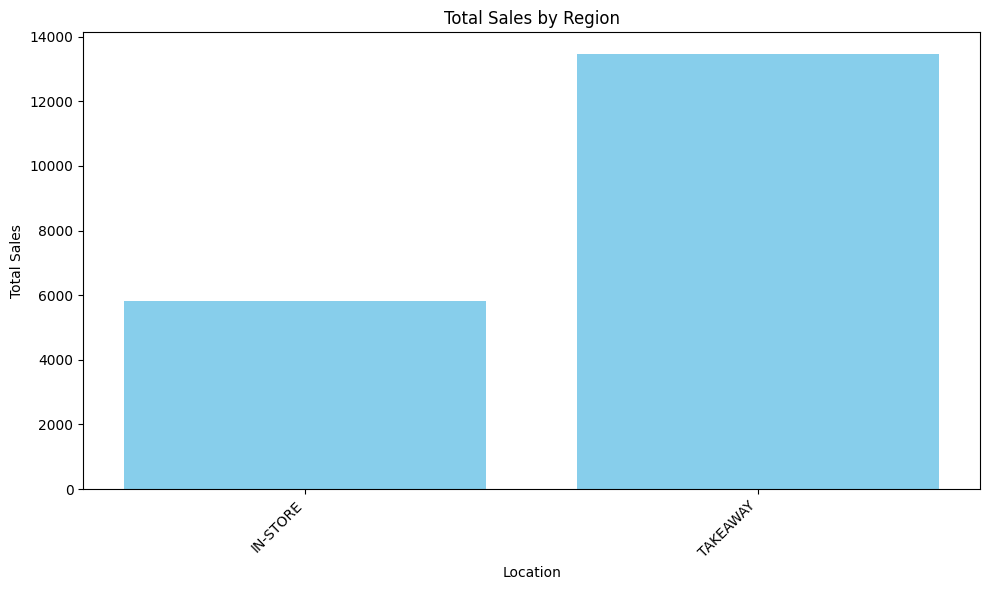

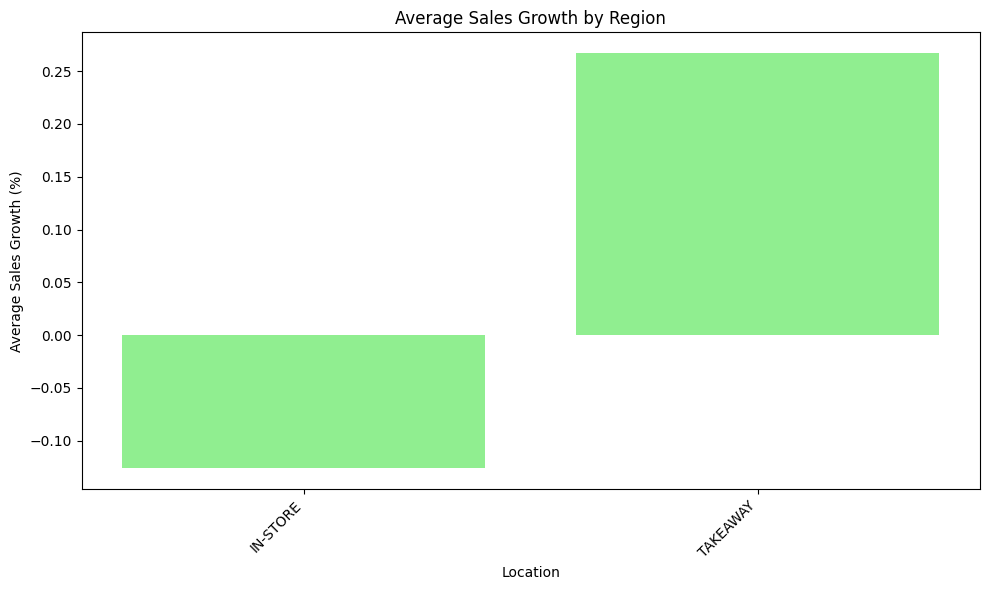

In [33]:
#data is by the form data frame
# Sample Data Preparation (replace with your actual dataset)
# Assuming 'Location' column represents the region

# Step 1: Group by Location and calculate total sales, total quantity, average spend, and sales growth
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'])  # Ensure datetime format
data['Month'] = data['Transaction Date'].dt.to_period('M')  # Add a Month Period for growth analysis

# Group by Location to get total sales and other statistics
region_sales = data.groupby('Location').agg(
    total_sales=('Total Spent', 'sum'),
    total_quantity=('Quantity', 'sum'),
    average_spend=('Total Spent', 'mean'),
    average_quantity=('Quantity', 'mean')
).reset_index()

# Step 2: Calculate Sales Growth (assuming monthly data)
# We will use the 'Month' column and calculate the sum of total sales by month and region
monthly_sales = data.groupby(['Location', 'Month']).agg(
    total_sales_month=('Total Spent', 'sum')
).reset_index()

# Step 3: Calculate the growth in sales by region over months
monthly_sales['previous_sales'] = monthly_sales.groupby('Location')['total_sales_month'].shift(1)
monthly_sales['sales_growth'] = (monthly_sales['total_sales_month'] - monthly_sales['previous_sales']) / monthly_sales['previous_sales'] * 100
monthly_sales = monthly_sales.dropna()  # Drop rows with NaN values (for first month in each region)

# Step 4: Merge sales growth with region-level summary
region_sales_growth = monthly_sales.groupby('Location').agg(
    average_growth=('sales_growth', 'mean')
).reset_index()

# Step 5: Combine region-level sales analysis and sales growth data
region_analysis = pd.merge(region_sales, region_sales_growth, on='Location', how='left')

# Step 6: Display the final results (Total Sales, Average Sales, Growth)
print(region_analysis)

# Step 7: Visualization - Bar plot of Total Sales by Region
plt.figure(figsize=(10, 6))
plt.bar(region_analysis['Location'], region_analysis['total_sales'], color='skyblue')
plt.xlabel('Location')
plt.ylabel('Total Sales')
plt.title('Total Sales by Region')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Step 8: Visualization - Sales Growth by Region (Average Growth)
plt.figure(figsize=(10, 6))
plt.bar(region_analysis['Location'], region_analysis['average_growth'], color='lightgreen')
plt.xlabel('Location')
plt.ylabel('Average Sales Growth (%)')
plt.title('Average Sales Growth by Region')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
